In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
import tensorflow.compat.v1 as tf
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import tensorflow_hub as hub
import time

from tensorflow.keras.applications.efficientnet import EfficientNetB0 as Net
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-09-19 11:53:45.878499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 11:53:46.472063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_data(limit: int = None, dir: str = "./roboflow/"):
    train, valid, test = list(), list(), list()

    for path, dirs, files in os.walk(dir):
        if not "scissors" in path and not "rock" in path and not "paper" in path:
            continue

        for name in files:
            file_name = os.path.join(path, name)

            if "train" in path:
                train.append(file_name)
            elif "valid" in path:
                valid.append(file_name)
            elif "test" in path:
                test.append(file_name)

    if limit:
        train = random.sample(train, limit)
        valid = random.sample(valid, limit)
        test = random.sample(test, limit)

    return train, valid, test


In [3]:
def gen_plt(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_x = range(len(acc))

    plt.plot(epochs_x, acc, "bo", label="Training acc")
    plt.plot(epochs_x, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs_x, loss, "bo", label="Training loss")
    plt.plot(epochs_x, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    return plt


In [4]:
def predict_image(
        model, width: int = 150, height: int = 150, img: str = None, indices: tuple = None):
    lookup = dict((y, x) for x, y in indices.items())
    img = image.load_img(img, target_size=(width, height))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255.0

    # print(indices)
    # print(lookup)
    # print(model.predict([x]))

    return lookup[np.argmax(model.predict([x]), axis=1)[0]]

In [5]:
train_data, valid_data, test_data = get_data()

width, height = 150, 150
input_shape = (height, width, 3)

batch_size = 10
epochs = 100
dropout = 0.2

NUM_TRAIN = sum([len(files) for r, d, files in os.walk("./roboflow/train/")])
NUM_TEST = sum([len(files) for r, d, files in os.walk("./roboflow/test/")])


In [6]:
train_gen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = ImageDataGenerator(rescale=1.0 / 255)

train = train_gen.flow_from_directory(
    "./roboflow/train",
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

valid = test_gen.flow_from_directory(
    "./roboflow/valid",
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [7]:
conv_base = Net(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.summary()

2023-09-19 11:53:47.340348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 11:53:47.355169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 11:53:47.355326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
if dropout > 0:
    model.add(layers.Dropout(dropout, name="dropout_out"))
model.add(layers.Dense(3, activation="softmax", name="fc_out"))

conv_base.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [9]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
)

start = time.time()
history = model.fit_generator(
    train,
    steps_per_epoch=NUM_TRAIN // batch_size,
    epochs=epochs,
    validation_data=valid,
    validation_steps=NUM_TEST // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=os.cpu_count(),
)
print(f"elasped_time: {execution_time:.4f} 초")

Epoch 1/100


/tmp/ipykernel_410622/1608892832.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-09-19 11:53:49.455068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-19 11:53:53.029443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8904


  1/252 [..............................] - ETA: 16:55 - loss: 1.1414 - acc: 0.5000

2023-09-19 11:53:53.328717: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-19 11:53:53.371029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-19 11:53:53.376197: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fcfb800a900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-19 11:53:53.376212: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-09-19 11:53:53.379356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-19 11:53:53.419207: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
20

243/252 [===========================>..] - ETA: 0s - loss: 2.1565 - acc: 0.3202

2023-09-19 11:53:55.136325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - 8s 15ms/step - loss: 2.1473 - acc: 0.3218 - val_loss: 1.3552 - val_acc: 0.3667
Epoch 2/100
252/252 [==============================] - 4s 12ms/step - loss: 2.0177 - acc: 0.3302 - val_loss: 1.3500 - val_acc: 0.2333
Epoch 3/100
252/252 [==============================] - 4s 13ms/step - loss: 1.9242 - acc: 0.3460 - val_loss: 1.8226 - val_acc: 0.2667
Epoch 4/100
252/252 [==============================] - 4s 15ms/step - loss: 1.8292 - acc: 0.3329 - val_loss: 1.1800 - val_acc: 0.2667
Epoch 5/100
252/252 [==============================] - 4s 12ms/step - loss: 1.8286 - acc: 0.3262 - val_loss: 1.7598 - val_acc: 0.5000
Epoch 6/100
252/252 [==============================] - 5s 15ms/step - loss: 1.7864 - acc: 0.3254 - val_loss: 1.5630 - val_acc: 0.2667
Epoch 7/100
252/252 [==============================] - 4s 13ms/step - loss: 1.7155 - acc: 0.3540 - val_loss: 2.9566 - val_acc: 0.1667
Epoch 8/100
252/252 [==============================] - 4s 14ms/step - loss

KeyboardInterrupt: 

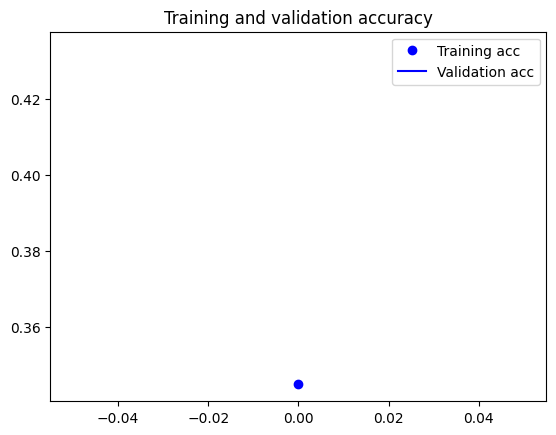

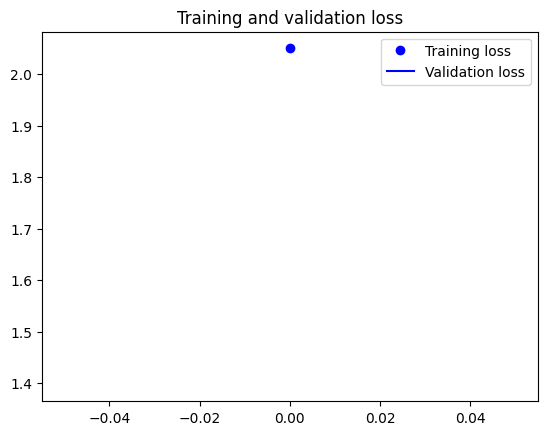

In [ ]:
gen_plt(history).show()

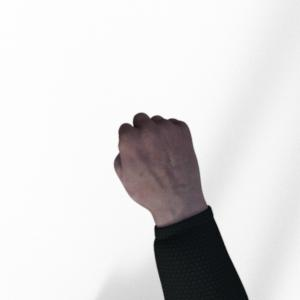

In [ ]:
random_test_image = random.choice(test_data)
Image(filename=random_test_image)

In [ ]:
predict_image(model, img=random_test_image, indices=train.class_indices)

1/1 [==============================] - 1s 645ms/step


'rock'

In [ ]:
tf.keras.backend.clear_session()
sys.path.append('./automl/efficientnetv2/')

In [ ]:
import effnetv2_model

ev2 = effnetv2_model.EffNetV2Model(model_name='efficientnetv2-s', include_top=False)
ev2.build(input_shape=(None, width, height, 3))
ev2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 stem (Stem)                 (None, 112, 112, 24)      744       
                                                                 
 blocks_0 (FusedMBConvBlock)  (None, 112, 112, 24)     5280      
                                                                 
 blocks_1 (FusedMBConvBlock)  (None, 112, 112, 24)     5280      
                                                                 
 blocks_2 (FusedMBConvBlock)  (None, 56, 56, 48)       25920     
                                                                 
 blocks_3 (FusedMBConvBlock)  (None, 56, 56, 48)       93120     
                                                                 
 blocks_4 (FusedMBConvBlock)  (None, 56, 56, 48)       93120 

In [ ]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[width, height, 3]),
    effnetv2_model.EffNetV2Model(
        model_name='efficientnetv2-s', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        3, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None, width, height, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (EffNetV2M  (None, 1280)             20331360  
 odel)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 20,335,203
Trainable params: 20,181,331
Non-trainable params: 153,872
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])


history = model.fit(
    train,
    steps_per_epoch=NUM_TRAIN // batch_size,
    epochs=epochs,
    validation_data=valid,
    validation_steps=NUM_TEST // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=os.cpu_count(),
)


2023-09-19 11:51:24.924982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.5829

2023-09-19 11:51:48.121084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - 26s 59ms/step - loss: 0.9566 - accuracy: 0.5829 - val_loss: 0.5936 - val_accuracy: 0.7667


In [ ]:
predict_image(model, img=random_test_image, indices=train.class_indices)

1/1 [==============================] - 1s 1s/step


'rock'

In [ ]:
gen_plt(history).show()